In [1]:
#Import Statements 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import mini_imagenet_dataloader as TripletDataloader
import numpy as np

In [2]:
#Functions for use: 
def getLabels(classes):
    result = []
    for i in classes:
        if i[0] == i[1]:
            result.append(1)
        else:
            result.append(0)
    return result


def resultsCounter(corr, count, res, label):
    for i in range(len(label)):
        if(res[i] == label[i]):
            corr += 1
        count += 1
    return corr, count

def getAcc(res,label):
    n = len(label)
    corr = 0 
    count = 0 
    for i in range(len(label)):
        if(res[i] == label[i]):
            corr += 1
        count += 1
    acc = (corr/count)*100.0
    return acc
    

def compareDistance(d1, d2):
    result = []
    for i in range(len(d1)):
        if (d1[i] < d2[i]):
            result.append(1)
        else:
            result.append(0)
    return result


In [3]:
#Design the network 

class TripletNet(nn.Module):
    def __init__(self, convNet):
        super(TripletNet, self).__init__()
        self.convNet = convNet

    def forward(self, x, y, z):
        embedded_x = self.convNet(x)
        embedded_y = self.convNet(y)
        embedded_z = self.convNet(z)
        dist_a = F.pairwise_distance(embedded_x, embedded_y, 2)
        dist_b = F.pairwise_distance(embedded_x, embedded_z, 2)
        return dist_a, dist_b, embedded_x, embedded_y, embedded_z
    
    
class SaimeseConv(torch.nn.Module):
    def __init__(self):
        super(SaimeseConv, self).__init__()
      
        self.conv1 = nn.Conv2d(1, 32, 14)
        self.conv2 = nn.Conv2d(32, 64, 12)
        #self.conv3 = nn.Conv2d(128, 256, 4)
        self.conv4 = nn.Conv2d(64, 128, 10)
        self.pool = nn.MaxPool2d(2)
        self.linear1 = nn.Linear(128*8*8, 2048)
        self.linear2 = nn.Linear(2048, 10)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        #print(x.shape)
        x = self.conv1(x)
        #print(x.shape)
        x = F.relu(x)
        x = self.pool(x)
        #print(x.shape)

        x = self.conv2(x)
        #print(x.shape)
        x = F.relu(x)
        x = self.pool(x)
        #print(x.shape)
        x = self.conv4(x)
        #print(x.shape)
        x = F.relu(x)
        #print(x.shape)
        x = x.view(x.shape[0], -1)
        #print(x.shape)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        return x

In [5]:
#Set up dataloader and select hyperparameters: .
width = 105
height = 105
batchSize = 60 

#trainSet, testSet = TripletDataloader.main('parsedimagenetdata300.csv',0.9, 12, width, height)

"""
TODO: Make a custom DataLoader 
generate a Test set and train Set from the sample Dataset 

"""
from TripletImagenetloader import * 

data = readModelCSV("Tripletimagenetdata.csv")

trainset,testset = splitdata(0.9,data)

#Assign Dataloaders here: 


trainLoader = DataLoader(TripletData(trainset, width, height), batch_size=batchSize, shuffle=True)
testLoader = DataLoader(TripletData(testset, width, height), batch_size=batchSize, shuffle=True)
print("Succesfully Loaded Data")


numClass = 200
from model import * 
#model = SaimeseConv()
model = Siamese()
tnet = Triplet(model).cuda()

print(list(tnet.parameters()))
tnet.train()

optimizer = optim.Adam(tnet.parameters(),lr = 0.0002)

optimizer.zero_grad()
criterion = nn.TripletMarginLoss(margin=0.5, p=2)

Shape of Data, L: 16000 , W:6
Train:  (14400, 6)
Test:  (1600, 6)
Succesfully Loaded Data
[Parameter containing:
tensor([[[[-1.5248e-02, -5.7711e-02, -2.6818e-02,  ..., -5.7818e-02,
            6.8546e-02,  5.2799e-02],
          [ 8.9036e-04, -4.8615e-02, -6.0087e-03,  ...,  4.6359e-02,
           -1.7925e-02, -8.2452e-02],
          [-5.7103e-02,  8.1147e-02,  4.6008e-02,  ..., -5.9321e-02,
            9.6800e-03,  2.7046e-02],
          ...,
          [ 8.0541e-02, -6.5832e-02,  2.2026e-02,  ...,  8.6006e-02,
            6.2787e-02,  2.9782e-02],
          [-5.0670e-02,  3.0150e-02, -9.3882e-02,  ..., -5.0903e-02,
           -1.2928e-02, -6.7389e-04],
          [ 1.6398e-02, -8.4696e-02, -7.1131e-02,  ...,  4.5238e-04,
           -4.9604e-03,  5.9949e-02]]],


        [[[-9.6662e-02, -9.7465e-02,  8.3929e-02,  ..., -4.4955e-02,
           -3.9351e-02, -4.1300e-02],
          [-4.1843e-02,  8.2686e-02, -8.9565e-02,  ..., -1.2057e-02,
            9.7487e-02,  8.2373e-02],
          [ 

In [7]:
#loop to Train Network on Second Dataset: 
print("~~~~~~~~~~~~~~Training~~~~~~~~~~~~~~~~")

trainCorrect = 0
trainCount = 0
loss_count = []
acc_count = [] 

for epoch in range(0,5):
    for batch_i, batch_data in enumerate(trainLoader):
        A, P, N, classes = batch_data['A'],batch_data['P'], batch_data['N'],batch_data['class']
        optimizer.zero_grad()

        A = A.unsqueeze(1)
        P = P.unsqueeze(1)
        N = N.unsqueeze(1)
        # x1: A,  x2: P, x3: N
        x1 = Variable(torch.tensor(A, dtype=torch.float32)).cuda()
        x2 = Variable(torch.tensor(P, dtype=torch.float32)).cuda()
        x3 = Variable(torch.tensor(N, dtype=torch.float32)).cuda()
        #print(x1.shape)
        y = Variable(torch.tensor(getLabels(classes),dtype=torch.float32)).cuda()
        
        dista, distb, out1, out2, out3 = tnet(x1, x2, x3)
   
        result = compareDistance(dista, distb)
        trainCorrect, trainCount = resultsCounter(trainCorrect, trainCount, result, y)
        
        loss = criterion(out1, out2, out3)
        if(batch_i%100==0):
            acc = getAcc(result,y)
            print("[%d]   Loss :%f | Accuracy = %f"  %(batch_i,loss.item(),acc) )
            loss_count.append(loss.item())
            acc_count.append(acc)
        
        
        #print(loss.item())
        #loss_triplet = criterion(dista, distb, target)
        #loss_embedd = embedded_x.norm(2) + embedded_y.norm(2) + embedded_z.norm(2)
        #loss = loss_triplet + 0.001 * loss_embedd
        
        
        loss.backward()
        optimizer.step()
    print("Training Accuracy: ", trainCorrect/trainCount)
    print("Loss: %f at Epoch: %d" %(loss.item(),epoch) )

~~~~~~~~~~~~~~Training~~~~~~~~~~~~~~~~


/home/mushy/anaconda3/envs/keras-gpu-2/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/mushy/anaconda3/envs/keras-gpu-2/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/mushy/anaconda3/envs/keras-gpu-2/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[0]   Loss :0.523957 | Accuracy = 51.666667
[100]   Loss :0.456596 | Accuracy = 50.000000
[200]   Loss :0.500608 | Accuracy = 63.333333
Training Accuracy:  0.5274305555555555
Loss: 0.459517 at Epoch: 0
[0]   Loss :0.488492 | Accuracy = 53.333333
[100]   Loss :0.523848 | Accuracy = 48.333333
[200]   Loss :0.504710 | Accuracy = 51.666667
Training Accuracy:  0.524375
Loss: 0.544390 at Epoch: 1
[0]   Loss :0.575816 | Accuracy = 53.333333
[100]   Loss :0.483366 | Accuracy = 55.000000
[200]   Loss :0.498682 | Accuracy = 45.000000
Training Accuracy:  0.5211111111111111
Loss: 0.466057 at Epoch: 2
[0]   Loss :0.516454 | Accuracy = 41.666667
[100]   Loss :0.492653 | Accuracy = 53.333333
[200]   Loss :0.511477 | Accuracy = 55.000000
Training Accuracy:  0.5217881944444445
Loss: 0.504945 at Epoch: 3
[0]   Loss :0.487400 | Accuracy = 46.666667
[100]   Loss :0.462844 | Accuracy = 56.666667
[200]   Loss :0.512543 | Accuracy = 50.000000
Training Accuracy:  0.5223472222222222
Loss: 0.504543 at Epoch: 4


In [6]:
#Loop To TEST Network On First DataSet: 

print("\n\n~~~| Testing |~~~")
model.eval()
testCorrect = 0
testCount = 0

for batch_i, test_data in enumerate(testLoader):
    A, P, N, classes = test_data['A'],test_data['P'], test_data['N'],test_data['class']
    A = A.unsqueeze(1)
    P = P.unsqueeze(1)
    N = N.unsqueeze(1)
    # x1: A,  x2: P, x3: N
    x1 = Variable(torch.tensor(A, dtype=torch.float32)).cuda()
    x2 = Variable(torch.tensor(P, dtype=torch.float32)).cuda()
    x3 = Variable(torch.tensor(N, dtype=torch.float32)).cuda()
    #print(x1.shape)
    y = Variable(torch.tensor(getLabels(classes),dtype=torch.float32)).cuda()

    dista, distb, out1, out2, out3 = tnet(x1, x2, x3)
    result = compareDistance(dista, distb)
            
    testCorrect, testCount = resultsCounter(testCorrect, testCount, result, y)
    print("Loss: ", round(loss.item(),5))
    print("Generated: ", result)
    print("Label: ", y)

print("Testing Accuracy: ",testCorrect/testCount)
    



~~~| Testing |~~~
Loss: 

/home/mushy/anaconda3/envs/keras-gpu-2/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/mushy/anaconda3/envs/keras-gpu-2/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/home/mushy/anaconda3/envs/keras-gpu-2/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


 0.5
Generated:  [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Label:  tensor([1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0.,
        0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1.,
        0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
Loss:  0.5
Generated:  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Label:  tensor([0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1.,
    

Loss:  0.5
Generated:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Label:  tensor([1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0.,
        0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
        0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1.,
        0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1.,
        0., 0., 1., 1., 0., 1., 1., 1.], device='cuda:0')
Loss:  0.5
Generated:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Label:  tensor([1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0.

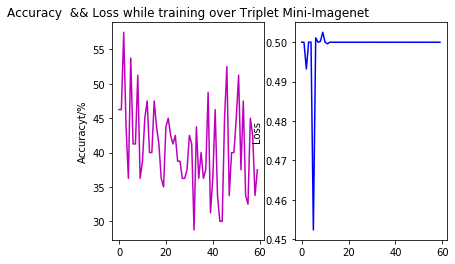

In [7]:
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.plot(acc_count,'m-')
ax1.set_ylabel("Accuracyt/%")
ax1.set_title("Accuracy  && Loss while training over Triplet Mini-Imagenet")
ax2.plot(loss_count,'b-')
ax2.set_ylabel("Loss")
ax2.set_title("")
plt.show()

In [8]:
"""
Set Up Omniglot Training and Testing 
"""
from TripletImagenetloader import * 

data = readModelCSV("TripletOmniglotdata.csv")

Otrainset,Otestset = splitdata(0.9,data)
OtrainLoader = DataLoader(TripletData(Otrainset, width, height), batch_size=batchSize, shuffle=True)
OtestLoader = DataLoader(TripletData(Otestset, width, height), batch_size=batchSize, shuffle=True)
print("Succesfully Loaded Data")

Shape of Data, L: 9640 , W:6
Train:  (8676, 6)
Test:  (964, 6)
Succesfully Loaded Data


In [9]:
#loop to Train Network on Second Dataset: 
print("~~~~~~~~~~~~~~Omniglot Training~~~~~~~~~~~~~~~~")

trainCorrect = 0
trainCount = 0
loss_count = []
acc_count = [] 
tnet.train()

for epoch in range(0,30):
    for batch_i, batch_data in enumerate(OtrainLoader):
        A, P, N, classes = batch_data['A'],batch_data['P'], batch_data['N'],batch_data['class']
        A = A.unsqueeze(1)
        P = P.unsqueeze(1)
        N = N.unsqueeze(1)
        # x1: A,  x2: P, x3: N
        x1 = Variable(torch.tensor(A, dtype=torch.float32)).cuda()
        x2 = Variable(torch.tensor(P, dtype=torch.float32)).cuda()
        x3 = Variable(torch.tensor(N, dtype=torch.float32)).cuda()
        #print(x1.shape)
        y = Variable(torch.tensor(getLabels(classes),dtype=torch.float32)).cuda()
        
        dista, distb, out1, out2, out3 = tnet(x1, x2, x3)
   
        result = compareDistance(dista, distb)
        trainCorrect, trainCount = resultsCounter(trainCorrect, trainCount, result, y)
        
        loss = criterion(out1, out2, out3)
        if(batch_i%100==0):
            acc = getAcc(result,y)
            print("[%d]   Loss :%f | Accuracy = %f"  %(batch_i,loss.item(),acc) )
            loss_count.append(loss.item())
            acc_count.append(acc)
        
        
        #print(loss.item())
        #loss_triplet = criterion(dista, distb, target)
        #loss_embedd = embedded_x.norm(2) + embedded_y.norm(2) + embedded_z.norm(2)
        #loss = loss_triplet + 0.001 * loss_embedd
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Training Accuracy: ", trainCorrect/trainCount)
    print("Loss: %f at Epoch: %d" %(loss.item(),epoch) )

~~~~~~~~~~~~~~Omniglot Training~~~~~~~~~~~~~~~~
[0]   Loss :0.500000 | Accuracy = 38.750000


/home/mushy/anaconda3/envs/keras-gpu-2/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/mushy/anaconda3/envs/keras-gpu-2/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/mushy/anaconda3/envs/keras-gpu-2/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[100]   Loss :0.500000 | Accuracy = 33.750000
Training Accuracy:  0.39983863531581376
Loss: 0.500000 at Epoch: 0
[0]   Loss :0.500000 | Accuracy = 45.000000
[100]   Loss :0.500000 | Accuracy = 33.750000
Training Accuracy:  0.39983863531581376
Loss: 0.500000 at Epoch: 1
[0]   Loss :0.500000 | Accuracy = 28.750000
[100]   Loss :0.500000 | Accuracy = 37.500000
Training Accuracy:  0.39983863531581376
Loss: 0.500000 at Epoch: 2
[0]   Loss :0.500000 | Accuracy = 31.250000
[100]   Loss :0.500000 | Accuracy = 41.250000
Training Accuracy:  0.39983863531581376
Loss: 0.500000 at Epoch: 3
[0]   Loss :0.500000 | Accuracy = 37.500000
[100]   Loss :0.500000 | Accuracy = 48.750000
Training Accuracy:  0.39983863531581376
Loss: 0.500000 at Epoch: 4
[0]   Loss :0.500000 | Accuracy = 33.750000
[100]   Loss :0.500000 | Accuracy = 41.250000
Training Accuracy:  0.39983863531581376
Loss: 0.500000 at Epoch: 5
[0]   Loss :0.500000 | Accuracy = 43.750000
[100]   Loss :0.500000 | Accuracy = 38.750000
Training Acc

In [10]:
#Loop To TEST Network On First DataSet: 

print("\n\n~~~|Omniglot  Testing |~~~")
model.eval()
testCorrect = 0
testCount = 0
tnet.eval()

for batch_i, test_data in enumerate(OtestLoader):
    A, P, N, classes = test_data['A'],test_data['P'], test_data['N'],test_data['class']
    A = A.unsqueeze(1)
    P = P.unsqueeze(1)
    N = N.unsqueeze(1)
    # x1: A,  x2: P, x3: N
    x1 = Variable(torch.tensor(A, dtype=torch.float32)).cuda()
    x2 = Variable(torch.tensor(P, dtype=torch.float32)).cuda()
    x3 = Variable(torch.tensor(N, dtype=torch.float32)).cuda()
    #print(x1.shape)
    y = Variable(torch.tensor(getLabels(classes),dtype=torch.float32)).cuda()

    dista, distb, out1, out2, out3 = tnet(x1, x2, x3)
    result = compareDistance(dista, distb)
            
    testCorrect, testCount = resultsCounter(testCorrect, testCount, result, y)
    print("Loss: ", round(loss.item(),5))
    print("Generated: ", result)
    print("Label: ", y)

print("Testing Accuracy: ",testCorrect/testCount)



~~~|Omniglot  Testing |~~~
Loss:  0.5
Generated:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Label:  tensor([1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.,
        1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')


/home/mushy/anaconda3/envs/keras-gpu-2/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/home/mushy/anaconda3/envs/keras-gpu-2/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/home/mushy/anaconda3/envs/keras-gpu-2/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Loss:  0.5
Generated:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Label:  tensor([1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1.,
        0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0.,
        0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
        1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
        0., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
Loss:  0.5
Generated:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Label:  tensor([1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1.

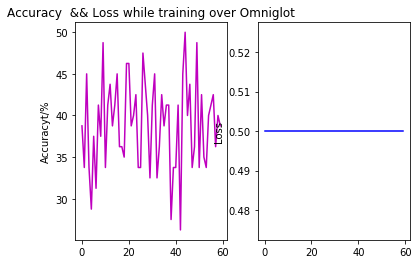

In [11]:
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.plot(acc_count,'m-')
ax1.set_ylabel("Accuracyt/%")
ax1.set_title("Accuracy  && Loss while training over Omniglot")
ax2.plot(loss_count,'b-')
ax2.set_ylabel("Loss")
ax2.set_title("")
plt.show()